**Note:** In order to run this notebook you have to have the GPU accelerator enabled (see notebook on requesting additional computing resources)

In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path
!TZ=America/New_York date

Already up to date.
Sat Feb 17 08:33:55 AM EST 2024


# Natural Language Processing: Deep Learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is part of a broader family of machine learning methods based on the layers used in artificial neural networks.  Here is how deep learning fits into the broader AI picture,

<img src="https://upload.wikimedia.org/wikipedia/commons/1/18/AI-ML-DL.png" height='500' width='500'>

# Deep Neural Networks

A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers. The DNN finds the correct mathematical manipulation to turn the input into the output, whether it be a linear relationship or a non-linear relationship. The network moves through the layers calculating the probability of each output.

DNNs can model complex non-linear relationships. DNN architectures generate compositional models where the object is expressed as a layered composition of primitives. The extra layers enable composition of features from lower layers, potentially modeling complex data with fewer units than a similarly performing shallow network

DNNs are typically feedforward networks in which data flows from the input layer to the output layer without looping back. At first, the DNN creates a map of virtual neurons and assigns random numerical values, or "weights", to connections between them. The weights and inputs are multiplied and return an output between 0 and 1. If the network doed accurately recognize a particular pattern, an algorithm (backpropagation) will adjust the weights appropriately.

<img src='https://i.stack.imgur.com/OH3gI.png' height='250' width='750'>

The difference between ANNs and DNNs is the number of hidden layers in the network.

# NLP and Deep Learning

DNNs are particularly well suited for NLP.  But before we look at this application we need to talk about `word embeddings`.

## From Vector Model to Word Embeddings

### The Vector Model

In the [document vector model](https://en.wikipedia.org/wiki/Vector_space_model) of a collection of documents each word that appears in the collection is defined as a dimension in the corresponding vector model and each document appears as a feature vector in this model.  Consider the following figure,

<!-- ![](https://ahmedbesbes.com/images/article_5/tfidf.jpg) -->

<!-- ![](https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg) -->

<img src="https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg" height="350" width="450">

Here each column represents the feature vector of one of the documents in the collection and the rows are the features or dimensions of the vectors. Notice that there is one feature for each word that appears in the collection of documents. The column vectors can be used for training a text classifier, that is, the transpose of the term-doc matrix shown here can be used directly as a training set for a classifier.

The fields in the term-doc matrix are the counts of how many times a word appears in a document.  However, there are many ways to encode the occurences of words in the collection within this matrix. In the binary `CountVectorizer`  the fields are just 0 and 1 indicating whether a particular word appears in a document or not. Perhaps the most famous encoding is [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf), short for term frequency–inverse document frequency.  Sklearn supports a [TD-IDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

### Disadvantages of the Vector Model

The vector representation of documents has two important consequences for document classification problems:

* The order and contexts of words are lost. To see the importance of the word context consider these [two sentences](https://jair.org/index.php/jair/article/view/11030): “it was not good, it was actually quite bad” and “it was not bad, it was actually quite good”.  The vector representation of these sentences is exactly the same but they obviously have very different meanings or classifications.  The vector representation of  documents is often  called the *bag of words* representation referring to the fact that it loses all order and context information.

In [2]:
# show the vector models of our two sentences
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

doc_names = ["sen1", "sen2"]
docs = ["it was not good, it was actually quite bad",
        "it was not bad, it was actually quite good"]

# process documents
vectorizer = CountVectorizer(analyzer = "word", binary = True)
docarray = vectorizer.fit_transform(docs).toarray()
coords = vectorizer.get_feature_names_out()
docterm = pd.DataFrame(data=docarray,index=doc_names,columns=coords)
print("\nDocterm:")
print(docterm)


Docterm:
      actually  bad  good  it  not  quite  was
sen1         1    1     1   1    1      1    1
sen2         1    1     1   1    1      1    1


*  Semantic similarities between words cannot be represented. To see the importance of semantic similarity consider one document that discusses dogs and another document that discusses puppies. From a vector model perspective the feature set for these two documents will not intersect in terms of the notion of dog because the vector model simply considers dogs and puppies to be two different features and the similarity of these documents will not be apparent to a machine learning algorithm.
```
Docterm:
           ...  dogs  puppies  ...
sen1    ...     1        0  ...
sen2    ...     0        1  ...
```

### Word Embeddings

Here words (not documents) are represented as [*embedding vectors*](https://en.wikipedia.org/wiki/Word_embedding) with the idea that two words that are semantically similar to each other have similar vectors. Consider the following figure,


 <img src="https://www.researchgate.net/profile/Tom_Kenter/publication/325451970/figure/fig1/AS:632023664304129@1527697592901/Visualization-of-3-dimensional-word-embeddings.png" height="200" width="250"/>

This figure represents a 3D embedding space and we can see that concepts that are similar to each other are close together in this embedding space.  Therefore the similarity of our two documents talking about dogs and puppies is expressed as a "vector simililarity" which is most often computed as the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) rather than comparing features directly,

<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png" height="200" width="800">

In other words, we are comparing the semantic notion of dogs and puppies rather than the precise syntax of the words.

Here is another example of five embedding vectors in a 2D embedding space,

<img src="https://raw.githubusercontent.com/lutzhamel/word2vec-simplified/master/word-vectors.png">

The five vectors represent the words,

* Red – Queen
* Blue – King
* Green – Man
* Black – Woman
* Yellow – Oil

Applying vector similarity here it becomes obvious that the vectors representing 'Man' and 'Woman' are most similar to each other, that is, they are semantically most closely related.  It is also easy to see that the vector representing 'Oil' is most dissimilar to all the other vectors.

One of the more popular word embeddings is [word2vec](https://en.wikipedia.org/wiki/Word2vec) created by Google which embeds words in a 300D vector space.  Sentences are now represented as a `len x 300` matrix (or tensor in DNN terminology) where `len` is the number of words in the sentence and `300` is the embedding dimension. That is, each word in a sentence is embedded in that 300D space.  The dimensions themselves are "statistical dimensions" and not any specific word calculated by the word embedding algorithm.

A GitHub repository that explores word2vec a little bit further can be found [here](https://github.com/lutzhamel/word2vec-simplified).

## Processing Documents for DNNs

In deep neural networks documents are no longer compressed into a vector representation of just word occurences.  Instead, deep neural networks process actual sequences of words (coded as a integers) as they appear in the documents thereby *maintaining the order and contexts* of words. Consider the following code snippet using the [Keras](https://keras.io) tokenizer applied to our two sentences from above,


In [3]:

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
# train tokenizer - since both sentences contain
# the same words we can train the tokenizer on
# just one of the sentences
tokenizer.fit_on_texts(["it was not good, it was actually quite bad"])
# print sequences
print(tokenizer.texts_to_sequences(["it was not good, it was actually quite bad"])[0])
print(tokenizer.texts_to_sequences(["it was not bad, it was actually quite good"])[0])
# print word index
print(tokenizer.word_index)


[1, 2, 3, 4, 1, 2, 5, 6, 7]
[1, 2, 3, 7, 1, 2, 5, 6, 4]
{'it': 1, 'was': 2, 'not': 3, 'good': 4, 'actually': 5, 'quite': 6, 'bad': 7}


These sequences can be directly fed into a deep neural network for training and classification. Notice that word order and context are nicely preserved in this representation.  This is very different from the Naive Bayes training from our previous NLP applications.

# A Deep Neural Network for Fake-News

The deep neural network we are using for our experiment can be seen here as a Python implementation using the [Keras](https://keras.io) deep learning library,

In [4]:
# data handling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from confint import classification_confint

Get our text data and preprocess it,

In [5]:
# get data
df = pd.read_csv('https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv')
df.head(n=10)

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [6]:
df.shape

(6335, 4)

In [7]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [8]:
# use the CountVectorizer to do some basic text cleanup

# build a new default analyzer using CountVectorizer that only
# uses words, [a-zA-Z]+, we could also eliminate stop words
# but eliminating stop words has a very limited effect on the outcome
analyzer= CountVectorizer(analyzer = "word",
                          #stop_words = 'english',
                          token_pattern = "[a-zA-Z]+").build_analyzer()

# the function that runs the analyzer on doc
def process_doc(doc):
    return " ".join(analyzer(doc))

**Observation**: Preprocessing has almost no effect on the accuracy of the model meaning that wordembedding can discover the important relationships with or without preprocessing.

In [9]:
#texts = df['text'].apply(process_doc)
texts = df['text']
texts.head(n=10)

0    Daniel Greenfield, a Shillman Journalism Fello...
1    Google Pinterest Digg Linkedin Reddit Stumbleu...
2    U.S. Secretary of State John F. Kerry said Mon...
3    — Kaydee King (@KaydeeKing) November 9, 2016 T...
4    It's primary day in New York and front-runners...
5      \nI’m not an immigrant, but my grandparents ...
6    Share This Baylee Luciani (left), Screenshot o...
7    A Czech stockbroker who saved more than 650 Je...
8    Hillary Clinton and Donald Trump made some ina...
9    Iranian negotiators reportedly have made a las...
Name: text, dtype: object

In [10]:
labels = df['label'].apply(lambda x: 1 if x == 'FAKE' else 0)

<Axes: xlabel='text', ylabel='Count'>

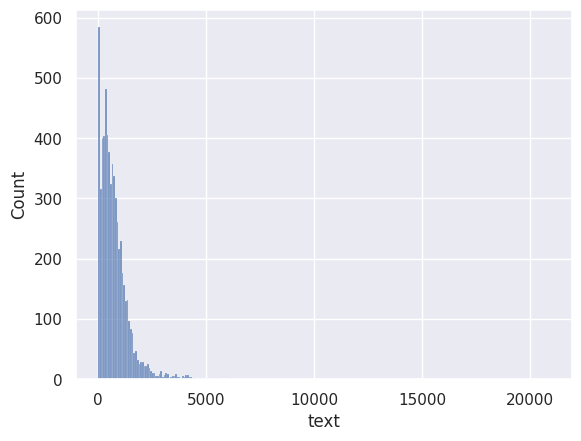

In [11]:
# plot the distribution of article lengths in terms of word counts
import seaborn as sns
sns.set()
text_lengths = texts.apply(lambda x: len(x.split(" ")))
sns.histplot(text_lengths)

From the graph above we see that the majority of documents have 5000 words or less.  Therefore we pick the constant `MAX_SEQUENCE_LENGTH` to be 5000.

In [12]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300

In [13]:
# vectorize the text samples into a 2D integer tensor

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
tok_data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')


print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', tok_data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [14]:
# split the data into a training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tok_data,
                                                  labels,
                                                  train_size=0.8,
                                                  test_size=0.2,
                                                  random_state=1)

In [15]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Our DNN can be broken down into two distinct parts. The first part consists of three layers and is responsible for  word and sequence processing:
1. The Embedding layer - learn word embeddings.
2. The Convolution layer - learn patterns throughout the text sequences.
3. The Pooling layer - filter out the interesting sequence patterns.

The second part consists of two layers,

1. A Dense layer with a ReLU activation function.
2. A Dense layer (also the output layer) with a Sigmoid activation function.

This part of the DNN can be viewed as a traditional feed-foward, back-propagation neural network with one hidden layer operating on a feature vector of length 128 computed by the first part of the DNN.   In order to see this perhaps a bit clearer, look at the summary of the DNN as compiled by Keras,



In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 300)         7500300   
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7709069 (29.41 MB)
Trainable params: 7709069 (29.41 MB)
Non-trainable params: 0 (0.00 Byte)
________________

The `None` in the *Output Shape* column simply denotes the *current batch size default*. That  means the pooling layer computes a feature vector of size 128 which is passed into dense layers of the feedforward network as we mentioned above.

The overall structure of the DNN can be understood as a preprocessor defined in the first part that is being trained to map text sequences into feature vectors in such a way that the weights of the second part can be trained to obtain optimal classification results from the overall network.

In [17]:
# train the model

model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
40/40 [==============================] - 23s 434ms/step - loss: 0.6221 - accuracy: 0.6665 - val_loss: 0.4577 - val_accuracy: 0.8027
Epoch 2/10
40/40 [==============================] - 12s 305ms/step - loss: 0.3384 - accuracy: 0.8629 - val_loss: 0.2729 - val_accuracy: 0.8832
Epoch 3/10
40/40 [==============================] - 12s 314ms/step - loss: 0.1773 - accuracy: 0.9365 - val_loss: 0.1747 - val_accuracy: 0.9337
Epoch 4/10
40/40 [==============================] - 13s 315ms/step - loss: 0.0862 - accuracy: 0.9767 - val_loss: 0.1625 - val_accuracy: 0.9290
Epoch 5/10
40/40 [==============================] - 13s 319ms/step - loss: 0.0411 - accuracy: 0.9929 - val_loss: 0.1271 - val_accuracy: 0.9479
Epoch 6/10
40/40 [==============================] - 12s 306ms/step - loss: 0.0160 - accuracy: 0.9992 - val_loss: 0.1414 - val_accuracy: 0.9416
Epoch 7/10
40/40 [==============================] - 13s 315ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1372 - val_accuracy: 0.9479

In [18]:
# Evaluate the model
import numpy as np
predict_y = np.rint(model.predict(X_test))
acc = accuracy_score(y_test, predict_y)
lb,ub = classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

40/40 [==============================] - 2s 26ms/step
Accuracy: 0.95 (0.94,0.96)


In [19]:
# build the confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, predict_y, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df))

Confusion Matrix:
     0    1
0  588   28
1   38  613
